<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

The purpose of this notebook is to build an NLP model to amke reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: 
https://arxiv.org/abs/1710.06071

Reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251


## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5aa449a5-24da-b3eb-ca75-8c5bf06ecaf1)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to ...

> Visualize, visualize, visualize

Let's write a function to read in all of the lines with python

In [6]:
# Create a function to read the lines of a document

def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings woth one string per line from the taget filenmae.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines

train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
test_lines = get_lines(data_dir + "test.txt")
dev_lines = get_lines(data_dir + "dev.txt")

In [10]:
sample_line = train_lines[1]
sample_line

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'

In [11]:
import re

temp_list = re.split(r'\t', sample_line)
len(temp_list[1].split())



49

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines: 11},
  ]
```


In [12]:
## My preprocessing function

def preprocess(lines):

  '''
  Takes a list of lines and reformats them as shown above.

  Args:
    Lines: a list containing the target value and text

  Returns:
    A structured dictionary

  '''

  formatted_list = []

  for i, line in enumerate(lines):

    temp = re.split(r'\t', line)
    target = temp[0]

    try: 
      text = temp[1]
    except IndexError:
      text = 'None'

    length = len(text.split())

    small_dict = {'line_number': i,
                  'target': target,
                  'text': text,
                  'total_lines': length}

    formatted_list.append(small_dict)

  return formatted_list


In [13]:
train_lines = train_lines[1:]
train_lines[:20]

preprocessed_train = preprocess(train_lines)

In [14]:
preprocessed_train[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines': 49},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'total_lines': 27},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'total_lines': 15},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'total_lines': 14},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures

In [15]:
# Not my preprocessing function

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] #create an empty list of acstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
       abstract_id = line
       abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line. isa new line
       abstract_line_split = abstract_lines.splitlines() # split abstract into separate

       # Iterate through each line in a single abstract and count them at the same time
    
       for abstract_line_number, abstract_line in enumerate(abstract_line_split):
          line_data = {} # create an empty dict for each line
          target_text_split = abstract_line.split("\t") # split target label from text
          line_data["target"] = target_text_split[0]
          line_data["text"] = target_text_split[1].lower() # get target text and lower it
          line_data["line_number"] = abstract_line_number # what number line does the line appear in
          line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract
          abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line 

  return abstract_samples

    


In [16]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+ "test.txt")


CPU times: user 422 ms, sys: 78.8 ms, total: 501 ms
Wall time: 502 ms


In [17]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to futher Visualize it

In [18]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [19]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [20]:
# Distribution of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

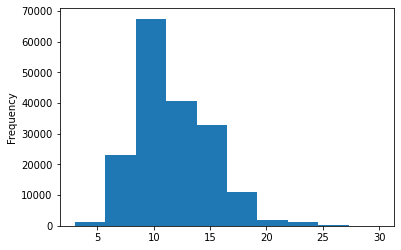

In [21]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

### Get lists of sentences

In [22]:
# Convert abstract text lines into lists

train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [23]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [24]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# check
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [25]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like

train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [26]:
# Get class names and number of classes from Label Encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

We will be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline(TF-IDF Multinomial Naive Bayes classifier).

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

baseline = Pipeline([
      ('tfidf', TfidfVectorizer()),
      ('clf', MultinomialNB())
])

baseline.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
baseline.score(X = val_sentences, y = val_labels_encoded)

0.7218323844829869

In [29]:
# Make predictions using our baseline model

baseline_preds = baseline.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [30]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In [31]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-03 01:08:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-03 01:08:29 (91.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [32]:
from helper_functions import calculate_results

In [33]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                      y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

---



Before we start building deeper models, we've got to createvectorization and embedding layers

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [35]:
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

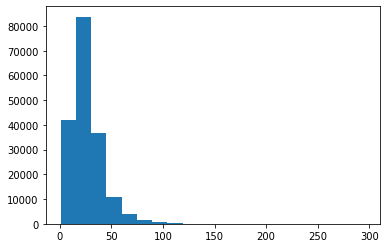

In [36]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20)

In [37]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [38]:
# Maximum sequence length in the training set

max(sent_lens)

296

### Create text vecotrizer layer

We want to make a layer which maps our texts from words to numbers

In [39]:
# How many words are in our vocab? (taken from table 2 in: paper)

max_tokens = 68000


In [40]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, output_sequence_length = output_seq_len)

In [41]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [42]:
# Text out text viectorizer on random sentneces

import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
urinary retention is one of the most common complications contributing to surgical procedures .

Length of text: 95

Vectorized text: [[ 616 1096   20   88    4    2  215  317  296 4910    6  306  705    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [43]:
# How many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [44]:
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

## Creating an embedding Layer

In [45]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(input_dim = len(rct_20k_text_vocab),
                            output_dim = 128,
                            mask_zero = True, # use masking to handle variable sequence length,
                            name = "token_embedding")

In [46]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}")
embedded_sentence = embedding_layer(vectorized_sentence)
print(f"\nEmbedded sentence: \n{embedded_sentence}")

Sentence before vectorization:
 urinary retention is one of the most common complications contributing to surgical procedures .

Sentence after vectorization (before embedding): 
 [[ 616 1096   20   88    4    2  215  317  296 4910    6  306  705    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded sentence: 
[[[ 0.02702836  0.00195356 -0.0337771  ...  0.02167005  0.00732923
   -0.03641764]
  [ 0.04963664 -0.04535805  0.03179056 ... -0.02404968 -0.03217383
   -0.04650361]
  [ 0.04067782 -0.02947393  0.04156714 ... -0.04830376  0.01571292
    0.02663777]
  ...
  [ 0.02130641 -0.01147512 -0.04229593 ...  0.03119539 -0.04978018
    0.03893829]
  [ 0.02130641 -0.01147512 -0.04229593 ...  0.03119539 -0.04978018
    0.03893829]
  [ 0.02130641 -0.01147512 -0.04229593 ...  0.03119539 -0.04978018
    0.03893829]]]


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API

In [53]:
# Turn our data into TensorFlow Datasets


train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [54]:
# Take the TensorSliceDataset's and turn them into prefetched datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [55]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile

model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [56]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
_________________________________________________

In [58]:
#history_model_1 = model_1.fit(train_dataset, 
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              #epochs = 3,
                              #validation_data = valid_dataset,
                              #validation_steps = int(0.1 * len(valid_dataset))) # only validate on 10% of batches

In [59]:
#model_1.evaluate(valid_dataset)

In [60]:
#model_1_pred_probs = model_1.predict(valid_dataset)
#model_1_pred_probs, model_1_pred_probs.shape

In [61]:
# Convert pred probs to classes
#model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
#model_1_preds

In [64]:
#model_1_results = calculate_results (y_true = val_labels_encoded,
                                    # y_pred = model_1_preds)

In [65]:
#model_1_results

## Universal Sentence Encoder

In [66]:
import tensorflow_hub as hub

#embed = hub.load(https://tfhub.dev/google/universal-sentence-encoder/4)

embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                 input_shape = [],
                                 dtype = tf.string,
                                 trainable = False,
                                 name = 'USE'
                                 )

In [67]:
model_2 = tf.keras.Sequential([
    embedding_layer,
    #tf.keras.layers.Conv1D(32, 5, padding = 'same', activation = 'relu'),
    #tf.keras.layers.
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [68]:
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu')(pretrained_embedding)
outputs = layers.Dense(5, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs = inputs, outputs = outputs)

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [69]:
model_2.compile(loss= 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [70]:
#model_3.fit(train_dataset, steps_per_epoch = (0.1*len(train_dataset)), epochs = 3, validation_data = valid_dataset, validation_steps=(0.1*len(valid_dataset)))

In [71]:
#model_3.evaluate(valid_dataset)

In [72]:
#model_2_pred_probs = model_3.predict(valid_dataset)


In [73]:
#model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
#model_2_preds

In [74]:
#model_2_results = calculate_results(val_labels_encoded, model_2_preds)
#model_2_results

## Model 3: Conv1D with character embeddings

The paper we're replicating shows they used a combination of token and character-level embeddings.

Now let's use character level embeddings

### Creating a charaxcter-level tokenuzer

In [75]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [76]:
# make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

#Text splitting non-character-;eve; sequence intp characters

split_chars(train_sentences[2])


'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n d   s y s t e m i c   i n f l a m m a t i o n   m a r k e r s   .'

In [77]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [78]:
# What's the average character length?

char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

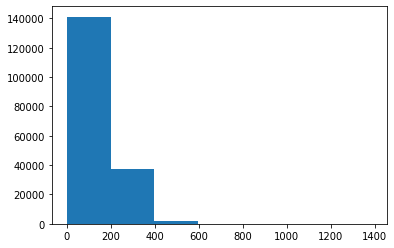

In [79]:
import matplotlib.pyplot as plt

plt.hist(char_lens, bins = 7);

In [80]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [81]:
# Get all keyboard characters

In [82]:
random.choice(train_sentences)

'at three participating clinics , @ patients at least @ months after stroke onset will be randomly allocated to an experimental virtual reality group ( eg ) or to a control group that will receive conventional physiotherapy or occupational therapy ( @ sessions , @ minutes each , over the course of @ weeks ) .'

In [83]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [84]:
# Create char-level token vecotrizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize = None,
                                    name = "char_vectorizer")

In [85]:
# Adapt charaxter vecotrizer to training characters

char_vectorizer.adapt(train_chars)

In [86]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
random_train_chars = random.choice(train_chars)

vectorized_chars = char_vectorizer([random_train_chars])
print(vectorized_chars)

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
tf.Tensor(
[[ 3 13  4  9  9  3 16 10 19  2 21  5 12 16  5  3  2 10  3 13  2 12  7  6
  18  3  2  8 15 15  7  6  3 13 11 12  4  6  4 11  5 12  2 17 17  2 11  3
   4 21  2  6  2  9  9  5  6 10  9  5 17  2  3 19  7 17  4  6 27  2 11  3
   4  7  6  7 17  6  7  6  5  6  4 15  5 12  9  3  5 22  4 12  4 25  2 10
  13 19  5 12 16  8  7  6  4 11  5 11  4 10 10  2 24  3  8  5  6  7 15  2
   8  6  5  9 13  5 10 24  7  6 17  4  9 19 15 14  3  7 15  9  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

# Creating a character level embedding layer

In [87]:
char_embed = tf.keras.layers.Embedding(len(char_vocab), 25, mask_zero = True, name = 'character_embedding')

In [88]:
# let's look at an example

embedded_sample_sent = char_embed(vectorized_chars)

print(f"Embedded sentence using a character level embedding: \n\n{embedded_sample_sent}")

Embedded sentence using a character level embedding: 

[[[-0.00781528 -0.03058553  0.01119366 ... -0.03999896  0.0004452
    0.00634166]
  [ 0.0044678  -0.03701379  0.04923883 ... -0.01972096 -0.01307078
    0.03017566]
  [-0.04965341 -0.03253057  0.00103278 ... -0.03285008 -0.02844194
   -0.04650625]
  ...
  [ 0.03915047  0.0263088  -0.02861368 ...  0.0432605   0.04975344
    0.01008568]
  [ 0.03915047  0.0263088  -0.02861368 ...  0.0432605   0.04975344
    0.01008568]
  [ 0.03915047  0.0263088  -0.02861368 ...  0.0432605   0.04975344
    0.01008568]]]


## Building a Conv1D Model on Character Embeddings

In [89]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(128, 5, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)

model_4 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_4')



In [90]:
model_4.compile(loss= 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [91]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
character_embedding (Embeddi (None, 290, 25)           700       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 128)          16128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325 

In [92]:
#look

train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Make datasets

In [93]:
x_train = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
x_val = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
x_test = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [94]:
dataset_train = x_train.batch(32).prefetch(tf.data.AUTOTUNE)
dataset_val = x_val.batch(32).prefetch(tf.data.AUTOTUNE)
dataset_test = x_test.batch(32).prefetch(tf.data.AUTOTUNE)

## Fit the model

In [95]:
#model_4.fit(dataset_train, epochs = 3, validation_data = dataset_val)

In [96]:
#model_4.evaluate(dataset_val)

In [97]:
#model_4.predict(val_chars)

In [98]:
#model_4_pred_probs = model_4.predict(val_chars)
#model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)

In [99]:
#model_4_preds[:5]

In [100]:
#calculate_results(val_labels_encoded, model_4_preds)

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_4` with a s;ight modification)
3. Combine with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2. 
5. Construct a model which takes token adn character-level sequences as inputs and produces sequence label probabilities as outputs

In [101]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape = [], dtype = tf.string, name = "tplen_input")
token_embeddings = embedding_layer(token_inputs) #the paper used glove embeddings
token_output = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #uses 50 in the paper 
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

#3. Cancatenate

token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

#4. Create output layers - adding in Dropout, discussed oin section 4.2 of paper

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

#5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

In [102]:
# Get a summary of our model

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
tplen_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   tplen_input[0][0]                
__________________________________________________________________

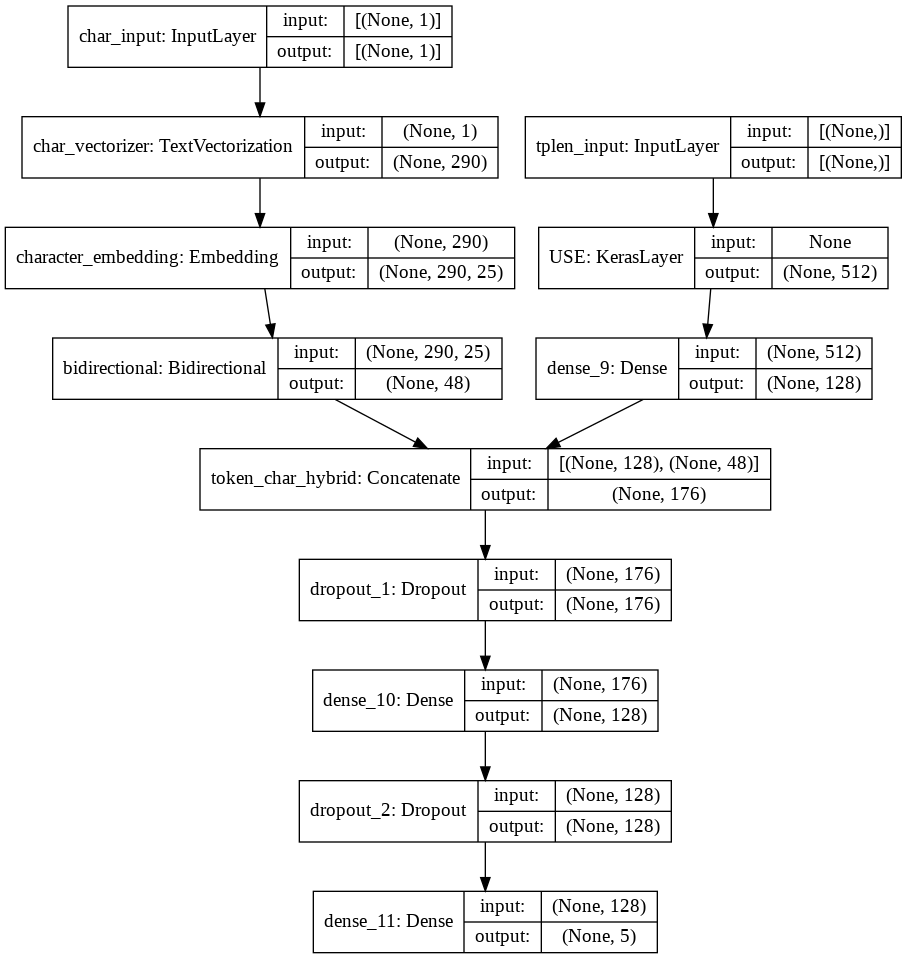

In [103]:
# Plot hybrid token and character model


from keras.utils.vis_utils import plot_model

plot_model(model_4, show_shapes = True)


In [104]:
# Compile token char model

model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(), # could use SGD
                metrics = ['accuracy'])

In [108]:
train_ct = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars), train_labels_one_hot)) # order matches model input
val_ct = tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars), val_labels_one_hot))
test_ct = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars), test_labels_one_hot))

In [110]:
train_ct = train_ct.batch(32).prefetch(tf.data.AUTOTUNE)
val_ct = val_ct.batch(32).prefetch(tf.data.AUTOTUNE)
test_ct = test_ct.batch(32).prefetch(tf.data.AUTOTUNE)

In [111]:
train_ct

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [117]:
model_4_history = model_4.fit(train_ct, steps_per_epoch = int(len(train_ct)*0.1), epochs = 3, validation_data = val_ct, validation_steps = int(len(val_ct)*0.1))

Epoch 1/3
562/562 [==============================] - 28s 49ms/step - loss: 0.7307 - accuracy: 0.7257 - val_loss: 0.6472 - val_accuracy: 0.7590
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.6993 - accuracy: 0.7355 - val_loss: 0.6395 - val_accuracy: 0.7610
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7033 - accuracy: 0.7321 - val_loss: 0.6318 - val_accuracy: 0.7600


In [113]:
#model_4.evaluate(val_ct)

945/945 [==============================] - 23s 24ms/step - loss: 0.6642 - accuracy: 0.7461


[0.6641512513160706, 0.7460611462593079]

In [120]:
model_4_pred_probs = model_4.predict(val_ct)

In [123]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)


In [125]:
calculate_results(val_labels_encoded, model_4_preds)

{'accuracy': 75.55607043558851,
 'f1': 0.75390526736152,
 'precision': 0.7548223708466906,
 'recall': 0.7555607043558851}